# Práctica 5: Ejemplos de aplicación de algortimos de Machine Learning

**Ingeniería Electrónica**

**Inteligencia Artificial**

**19/05/2021**

# 1. Árboles de decisión para diagnosticar cáncer de seno (mama) 

Luego de haber revisado los principios de Machine Learning, analizar un conjunto de datos real: el dataset de **_Breast Cancer Wisconsin_** (https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)).

Este conjunto de datos es un resultado de la investigación de imágenes médicas, y hoy se considera un ejemplo clásico. El conjunto de datos se creó a partir de imágenes digitalizadas de tejidos sanos (benignos) y cancerosos (malignos). Las imágenes se verían similares a la siguiente:

<img src="ejemplo_img.png">

Los investigadores realizaron la **extracción de características** en las imágenes. Pasaron por un total de 569 imágenes y extrajeron 30 características diferentes que describen las características de los núcleos celulares presentes en las imágenes, que incluyen:

* textura del núcleo celular (representada por la desviación estándar de los valores de la escala de grises)
* tamaño del núcleo celular (calculado como la media de las distancias desde el centro a los puntos en el perímetro)
* suavidad del tejido (variación local en longitudes de radio)
* compacidad tisular

El **objetivo** de la investigación fue clasificar las muestras de tejido en benignas y malignas (una tarea de **clasificación binaria**).

## Cargar el conjunto de datos
El conjunto de datos completo es parte de los conjuntos de datos de ejemplo de Scikit-Learn:

In [1]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

Todos los datos están contenidos en una matriz de datos 2D `data.data`, donde las filas representan muestras de datos y las columnas son los valores de las características:

In [2]:
data.data.shape

(569, 30)

Revisando los nombres de las características, reconocemos algunos de los que mencionamos anteriormente:

In [3]:
data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

Dado que esta es una tarea de clasificación binaria, esperamos encontrar exactamente dos nombres o categorías como objetivo:

In [4]:
data.target_names

array(['malignant', 'benign'], dtype='<U9')

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)

In [6]:
 X_train.shape, X_test.shape

((455, 30), (114, 30))

## Construyendo el árbol de decisión

In [7]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier()

In [8]:
dtc.fit(X_train, y_train)
dtc

DecisionTreeClassifier()

Como no especificamos ningún parámetro previo, esperaríamos que este árbol de decisión crezca bastante y resulte en una puntuación perfecta en el conjunto de entrenamiento:

In [9]:
dtc.score(X_train, y_train)

1.0

El error de prueba tampoco es malo:

In [13]:
dtc.score(X_test, y_test)

0.9385964912280702

### Visualización del árbol

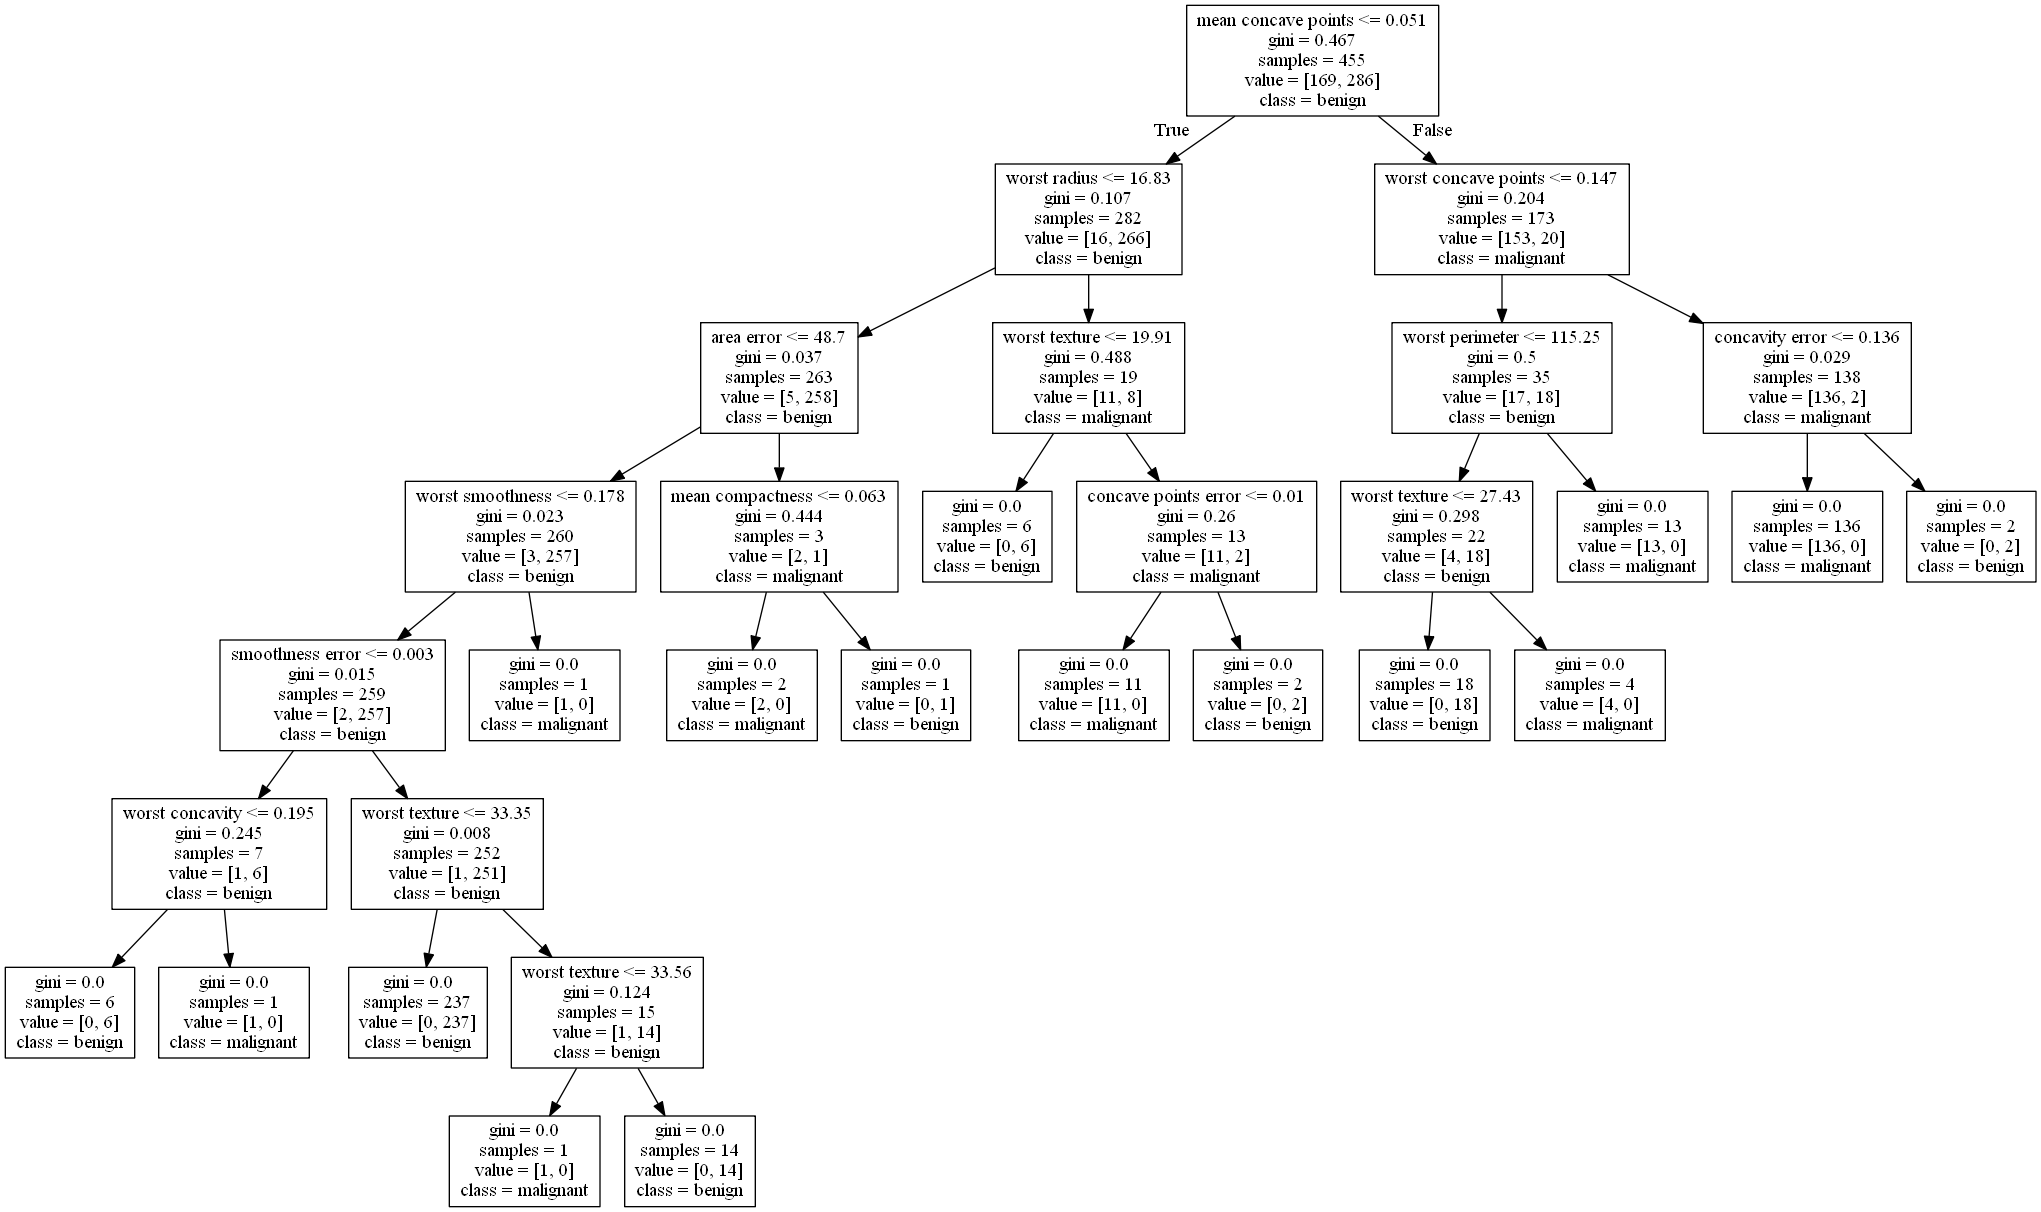

In [19]:
with open("tree.dot", 'w') as f:
        f = tree.export_graphviz(dtc, out_file=f,
                                 feature_names=data.feature_names,
                                 class_names=data.target_names)
!dot -Tpng tree.dot -o tree.png

from IPython.display import Image
Image("tree.png")

### Evaluación del modelo
Declaramos la función `mostrar_resultados` que genere un reporte de los resultados del modelo incluyendo la matriz de confusión.

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(3,3))
    sns.heatmap(conf_matrix, xticklabels=data.target_names, yticklabels=data.target_names, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

Llamamos a la función luego correr la predicción del modelo:

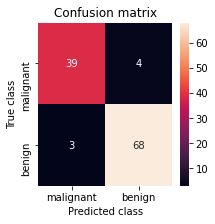

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        43
           1       0.94      0.96      0.95        71

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



In [21]:
y_pred = dtc.predict(X_test)
mostrar_resultados(y_test, y_pred)

In [22]:
# Puntaje por defecto es la exactitud
dtc.score(X_test, y_test)

0.9385964912280702

Obtener el área bajo la curva ROC, la cual una metrica más conservadora. La curva ROC es un gráfico de la tasa positiva verdadera versus la tasa positiva falsa en varios umbrales de probabilidad que van de 0 a 1.

In [23]:
from sklearn.metrics import roc_auc_score
prediction_prob = dtc.predict_proba(X_test)
pos_prob = prediction_prob[:, 1]

roc_auc_score(y_test, pos_prob)

0.932361611529643

Codifiquemos y exhibamos la curva ROC (bajo los umbrales de 0.0, 0.1, 0.2, ..., 1.0) de nuestro modelo:

In [24]:
import numpy as np
pos_prob = prediction_prob[:, 1]
thresholds = np.arange(0.0, 1.2, 0.1)
true_pos, false_pos = [0]*len(thresholds), [0]*len(thresholds)
for pred, y in zip(pos_prob, y_test):
    for i, threshold in enumerate(thresholds):
        if pred >= threshold:
            # si real y predicion son 1
            if y == 1:
                true_pos[i] += 1
                # si real es 0 mientras que la prediccion es 1
            else:
                false_pos[i] += 1
        else:
            break

Luego calcular las tasas de verdadero y falso positivo para todas las configuraciones de umbral (recordar que hay 71 muestras benignas y 43 malignas):

In [25]:
true_pos_rate = [tp / 71.0 for tp in true_pos]
false_pos_rate = [fp / 43.0 for fp in false_pos]

Ahora podemos trazar la curva ROC con matplotlib:

No handles with labels found to put in legend.


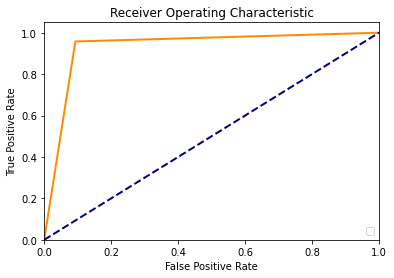

In [26]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='darkorange', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Varios modelos
Ahora queremos hacer una exploración de modelos. Por ejemplo, la profundidad de un árbol influye en su rendimiento. Si quisiéramos estudiar esta dependencia de manera más sistemática, podríamos repetir la construcción del árbol para diferentes valores de `max_depth`:

In [27]:
import numpy as np
max_depths = np.array([1, 2, 3, 5, 7, 9, 11])

Para cada uno de estos valores, queremos ejecutar modelo completo de principio a fin. También queremos guardar los puntajes del entramiento y  de la prueba. Hacemos esto en un bucle for:

In [28]:
train_score = []
test_score = []
for d in max_depths:
    dtc = tree.DecisionTreeClassifier(max_depth=d, random_state=42)
    dtc.fit(X_train, y_train)
    train_score.append(dtc.score(X_train, y_train))
    test_score.append(dtc.score(X_test, y_test))

Podemos trazar los puntajes en función de la profundidad del árbol usando Matplotlib:

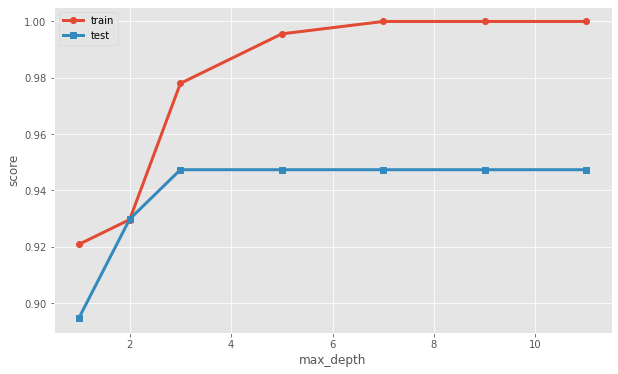

In [29]:
# import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_score, 'o-', linewidth=3, label='train')
plt.plot(max_depths, test_score, 's-', linewidth=3, label='test')
plt.xlabel('max_depth')
plt.ylabel('score')
plt.legend()

Se hace evidente cómo la profundidad del árbol influye en el rendimiento. Parece que cuanto más profundo es el árbol, mejor es el rendimiento en el conjunto de entrenamiento. 
Desafortunadamente, las cosas parecen un poco más confusas cuando se trata del rendimiento del conjunto de prueba. Aumentar la profundidad más allá del valor 3 no mejora aún más el puntaje de la prueba. ¿Quizás hay una configuración diferente de la que podríamos aprovechar que funcionaría mejor?

¿Qué pasa con el número mínimo de muestras requeridas para hacer de un nodo un nodo hoja?

Repetimos el procedimiento de arriba:

In [30]:
train_score = []
test_score = []
min_samples = np.array([2, 4, 8, 16, 32])
for s in min_samples:
    dtc = tree.DecisionTreeClassifier(min_samples_leaf=s, random_state=42)
    dtc.fit(X_train, y_train)
    train_score.append(dtc.score(X_train, y_train))
    test_score.append(dtc.score(X_test, y_test))

Esto lleva a una gráfica diferente de la anterior:

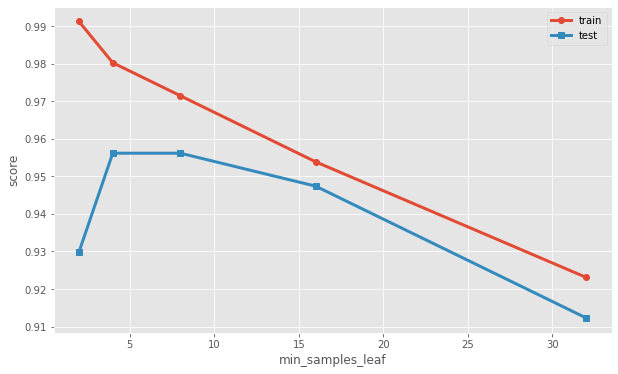

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(min_samples, train_score, 'o-', linewidth=3, label='train')
plt.plot(min_samples, test_score, 's-', linewidth=3,label='test')
plt.xlabel('min_samples_leaf')
plt.ylabel('score')
plt.legend()

Claramente, aumentar `min_samples_leaf` no aparenta bien con el puntaje de entrenamiento. **Pero eso no es necesariamente algo malo**, porque sucede algo interesante en la curva azul: el puntaje de prueba pasa por un máximo para valores entre 4 y 8, lo que lleva a un mejor puntaje de prueba que hemos encontrado hasta ahora: mayor a 95%.
Acabamos de aumentar nuestra puntuación inicial, simplemente ajustando los (hiper) parámetros del modelo.

## Ejercicio  

Una gran cantidad de buenos resultados en Machine Learning en realidad provienen de largas horas de exploraciones de modelos mediante prueba y error. Antes de generar una nueva gráfica, piensen en: ¿Cómo se esperaría que se vea la gráfica? ¿Cómo debería cambiar el puntaje de entrenamiento al comenzar a restringir el número de nodos hoja (**max_leaf_nodes**)? ¿Qué pasa con **min_samples_split**? Además, ¿cómo cambian las cosas cuando se cambia del índice de **Gini** a  ganancia de información (**information gain**)?

¿Cómo se esperaría que se vea la gráfica?: una grafica muy grande y extensa debido a las largas horas de entrenamiento.
¿Cómo debería cambiar el puntaje de entrenamiento al comenzar a restringir el número de nodos hoja (max_leaf_nodes)? el puntaje de entrenamiento deberia disminuir 
¿Qué pasa con min_samples_split? disminuye divido a que existe restriccion en el numero de nodos.
¿cómo cambian las cosas cuando se cambia del índice de Gini a ganancia de información (information gain)?

# 2. Árboles de decisión para regresión

Queremos usar un árbol de decisión para que un modelo se **ajuste a una onda Seno**. también agregaremos algo de ruido a los puntos de datos usando el generador de números aleatorios de NumPy:

In [32]:
import numpy as np
rng = np.random.RandomState(42)

Luego creamos 100 valores x entre 0 y 5, y calculamos los valores seno correspondientes:

In [33]:
X = np.sort(5 * rng.rand(100, 1), axis=0)
y = np.sin(X).ravel()

Luego agregamos ruido a cada punto de datos en y (usando `y[::2]`), escalado en 0.5 para que no introduzcamos demasiada variación:

In [34]:
y[::2] += 0.5 * (0.5 - rng.rand(50))

Una pequeña diferencia es que los criterios de división de Gini y la entropía no se aplican a las tareas de regresión. En cambio, scikit-learn proporciona dos criterios diferentes:

* 'mse' (también conocido como reducción de varianza): este criterio calcula el error cuadrático medio (MSE) entre el valor real y la predicción, y divide el nodo que conduce al MSE más pequeño.

* 'mae': este criterio calcula el error absoluto medio (MAE) entre el valor real y la predicción, y divide el nodo que conduce al MAE más pequeño.

Usando el criterio 'mse', construiremos dos árboles, uno con una profundidad de 2 y otro con una profundidad de 5:

In [35]:
from sklearn import tree
regr1 = tree.DecisionTreeRegressor(max_depth=2, random_state=42)
regr1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [36]:
regr2 = tree.DecisionTreeRegressor(max_depth=5, random_state=42)
regr2.fit(X, y)

DecisionTreeRegressor(max_depth=5, random_state=42)

Entonces podemos usar el árbol de decisión como un regresor lineal. Para esto, creamos un conjunto de prueba con valores de x  muestreados en todo el rango de 0 a 5:

In [37]:
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]

Los valores `y_n` pronosticados se pueden obtener con el método `predict`:

In [38]:
y_1 = regr1.predict(X_test)
y_2 = regr2.predict(X_test)

Si graficamos esto juntos, podemos ver cómo difieren los árboles de decisión:

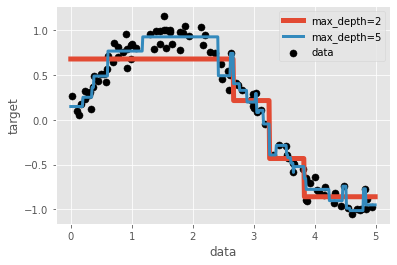

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.scatter(X, y, c='k', s=50, label='data')
plt.plot(X_test, y_1, label="max_depth=2", linewidth=5)
plt.plot(X_test, y_2, label="max_depth=5", linewidth=3)
plt.xlabel("data")
plt.ylabel("target")
plt.legend()

Aquí, la línea gruesa (en rojo) representa el árbol de regresión con profundidad 2. Se puede ver cómo el árbol intenta aproximar los datos utilizando estos pasos. La línea más delgada (en azul) pertenece al árbol de regresión con profundidad 5; La profundidad adicional ha permitido que el árbol tome decisiones mucho más finas. Por lo tanto, este árbol puede aproximar los datos aún mejor. Sin embargo, debido a esta potencia adicional, el árbol también es más susceptible a ajustar valores ruidosos, como se puede ver especialmente en el lado derecho de la gráfica.

# 3. Detección de peatones con SVM y OpenCV

Poco después de su introducción a principios de 1990, los SVM se hicieron rápidamente populares en la comunidad de ML, en gran parte debido a su éxito en la **clasificación temprana de dígitos escritos a mano**. Siguen siendo relevantes para este día, especialmente en aplicaciones como visión por computadora.

El objetivo es aplicar SVM a un problema popular en visión por computador: la **detección de peatones**. A diferencia del **reconocimiento** (donde nombramos la categoría de un objeto), el objetivo de la detección es el decir si un objeto en particular (o en nuestro caso, un peatón) está presente en una imagen o no.

En OpenCV es posible hacer esto en pocas líneas de código. Pero no aprenderemos nada si lo hacemos así. En cambio, construiremos todo el procesamiento desde cero. Obtendremos un conjunto de datos del mundo real, realizaremos la extracción de características utilizando el **histograma de gradientes orientados (HOG)** y le aplicaremos un SVM.

La idea básica detrás de la mayoría de los algoritmos de detección es dividir una imagen en muchos parches pequeños y 
luego clasificar cada parche de imagen en si contiene un peatón o no.
Para llegar a nuestro propio algoritmo de detección de peatones, debemos realizar los siguientes pasos:

1. Construir una **base de datos de imágenes que contengan peatones**. Estas serán nuestras muestras de datos "positivos".
2. Construir una **base de datos de imágenes que no contengan peatones**. Estas serán nuestras muestras de datos "negativos".
3. Entrenar a un SVM en el conjunto de datos.
4. Aplicar el SVM a cada parche de una imagen de prueba para determinar si la imagen contiene un peatón o no.

### Importar librerías

In [40]:
# conda install -c conda-forge opencv
# pip install opencv-python
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import os
#%matplotlib inline

## Obteniendo el conjunto de datos
Trabajaremos con el conjunto de datos de peatones del MIT, que es libre de usar para fines no comerciales. 

El conjunto de datos se puede obtener de http://cbcl.mit.edu/software-datasets/PedestrianData.html. El botón de descarga nos lleva a un archivo llamado http://cbcl.mit.edu/projects/cbcl/software-datasets/pedestrians128x64.tar.gz.

Sin embargo, dentro de la carptea pedestrians128x64 de esta práctica, se encuentran ya los archivos (.ppm) de imagen.

In [41]:
# directorio de imágenes. Como se encuentra en el mismo directorio del jupyter notebook,
# no es necesario especificar la ruta completa.
imgdir = "pedestrians128x64"

El conjunto de datos viene con un total de 924 imágenes en color de peatones, cada una escalada a 64 x 128 píxeles y alineada para que el cuerpo de la persona esté en el centro de la imagen. Escalar y alinear todas las muestras de datos es un paso importante del proceso.

Estas imágenes fueron tomadas en Boston y Cambridge en una variedad de estaciones del año y bajo diferentes condiciones de iluminación. Podemos visualizar algunas imágenes de ejemplo leyendo la imagen con OpenCV y pasando una versión RGB de la imagen a Matplotlib:

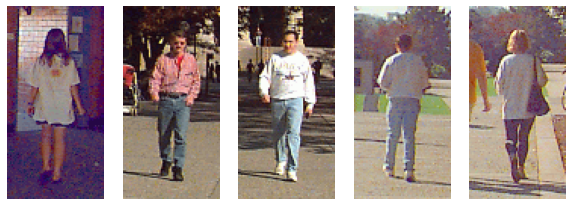

In [42]:
plt.figure(figsize=(10, 6))
for i in range(5):
    filename = "%s/per0010%d.ppm" % (imgdir, i)
    img = cv2.imread(filename)

    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

Parte del problema es encontrar una buena manera de representar estas imágenes. Debemos aplicar ingeniería de características (*feature engineering*).

## Revisar el histograma de gradientes orientados (HOG)

El HOG podría proporcionar la ayuda que estamos buscando para llevar a cabo esta tarea. HOG es un descriptor de características para imágenes. Se ha aplicado con éxito a diferentes tareas en visión por computador, y parece funcionar especialmente bien para clasificar a las personas.

La idea esencial detrás de las características del HOG es que las formas locales y la apariencia de los objetos dentro de una imagen se pueden describir mediante la distribución de las direcciones de los bordes. La imagen se divide en pequeñas regiones conectadas, dentro de las cuales se compila un histograma de direcciones de gradiente (o **direcciones de borde**). Luego, el descriptor se ensambla concatenando los diferentes histogramas. Un ejemplo se muestra en la siguiente imagen:

<img src="ejemplo_hog.png">

La imagen en el lado derecho muestra qué orientaciones de borde dominan en diferentes subregiones de la imagen. Se Puede ver por qué este descriptor sería particularmente adecuado para datos ricos en textura. Para mejorar el rendimiento, los histogramas locales también se pueden normalizar en contraste, lo que da como resultado una mejor invariancia a los cambios en la iluminación y el sombreado.

El descriptor HOG es accesible en OpenCV mediante `cv2.HOGDescriptor`, que toma varios de argumentos de entrada, como el tamaño de la ventana de detección (tamaño mínimo del objeto a detectar, 48 x 96), el tamaño del bloque (qué tan grande cada bloque es, 16 x 16), el tamaño de la celda (8 x 8) y el paso de la celda (cuántos píxeles mover de una celda a la siguiente, 8 x 8). Para cada una de estas celdas, el descriptor HOG calcula un histograma de gradientes orientados utilizando nueve contenedores:

In [43]:
win_size = (48, 96)
block_size = (16, 16)
block_stride = (8, 8)
cell_size = (8, 8)
num_bins = 9
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

Aunque esta llamada a la función parece complicada, estos son en realidad los únicos valores para los que se implementa el descriptor HOG. El argumento que más importa es el tamaño de la ventana (`win_size`).

Todo lo que queda por hacer es llamar a `hog.compute` en nuestras muestras de datos. Para esto, construimos un conjunto de datos de muestras positivas (`X_pos`) seleccionando aleatoriamente imágenes de peatones de nuestra carpeta. En la siguiente porción de código, seleccionamos al azar 400 imágenes de las más de 900 disponibles y les aplicamos el descriptor HOG:

In [44]:
random.seed(42)
X_pos = []
for i in random.sample(range(900), 400):
    filename = "%s/per%05d.ppm" % (imgdir, i)
    img = cv2.imread(filename)
    if img is None:
        print('No se pudo encontrar la imagen %s' % filename)
        continue
    X_pos.append(hog.compute(img, (64, 64)))

No se pudo encontrar la imagen pedestrians128x64/per00000.ppm


OpenCV requiere que la matriz de características contenga números de punto flotante de 32 bits y que las etiquetas de objetivo sean enteros de 32 bits. La conversión a matrices NumPy nos permitirá investigar fácilmente los tamaños de las matrices que creamos:

In [45]:
X_pos = np.array(X_pos, dtype=np.float32)
y_pos = np.ones(X_pos.shape[0], dtype=np.int32)
X_pos.shape, y_pos.shape

((399, 1980, 1), (399,))

Parece que elegimos un total de 399 muestras de entrenamiento, cada una de las cuales tiene 1980 valores de características (que son los valores de características del HOG).

## Generando negativos

Sin embargo, el verdadero desafío es encontrar el ejemplo perfecto de un "no peatón". Después de todo, es fácil pensar en imágenes de ejemplo de peatones. Pero, ¿qué es lo contrario de un peatón?

Este es realmente un problema común cuando se intenta resolver nuevos problemas de ML. Tanto los laboratorios de investigación como las empresas dedican mucho tiempo a crear y anotar nuevos conjuntos de datos que se ajustan a su propósito específico.

Una buena primera aproximación para encontrar lo opuesto a un peatón es reunir un conjunto de datos de imágenes que se parezcan a las imágenes de la clase positiva pero que no contengan peatones. Estas imágenes pueden contener cualquier cosa, como automóviles, bicicletas, calles, casas y tal vez incluso bosques, lagos o montañas.

Un buen lugar para comenzar es el conjunto de datos de escenas urbanas y naturales del Laboratorio de Cognición Visual Computacional del MIT. El conjunto de datos completo se puede obtener de http://olivalab.mit.edu/datasets.html, pero ya se ha recopilado una buena cantidad de imágenes de categorías como campo abierto, ciudades, montañas y bosques. Se encuentran en la carpeta `pedestrians_neg`:

In [46]:
negdir = "pedestrians_neg"

Todas las imágenes son en color, en formato `.jpeg` y tienen 256 x 256 píxeles. Sin embargo, para usarlos como muestras de una clase negativa que se combinan con nuestras imágenes de peatones anteriormente, debemos asegurarnos de que todas las imágenes tengan el mismo tamaño de píxel. Además, las cosas representadas en las imágenes deberían estar aproximadamente a la misma escala. Por lo tanto, queremos recorrer todas las imágenes en el directorio (a través de `os.listdir`) y recortar una región de interés (ROI) de 64 x 128:

In [47]:
hroi = 128
wroi = 64
X_neg = []
for negfile in os.listdir(negdir):
    filename = '%s/%s' % (negdir, negfile)
    img = cv2.imread(filename)
    img = cv2.resize(img, (512, 512))
    for j in range(5):
        rand_y = random.randint(0, img.shape[0] - hroi)
        rand_x = random.randint(0, img.shape[1] - wroi)
        roi = img[rand_y:rand_y + hroi, rand_x:rand_x + wroi, :]
        X_neg.append(hog.compute(roi, (64, 64)))

Algunos ejemplos de este procedimiento se muestran en la siguiente imagen:
<img src="ejemplo_neg.png">

Olvidamos asegurarnos de que todos los valores de caracteristicas son números de punto flotante de 32 bits. Además, la etiqueta de objetivo de estas imágenes debe ser -1, correspondiente a la clase negativa:

In [48]:
X_neg = np.array(X_neg, dtype=np.float32)
y_neg = -np.ones(X_neg.shape[0], dtype=np.int32)
X_neg.shape, y_neg.shape

((250, 1980, 1), (250,))

Luego podemos concatenar todas las muestras positivas (`X_pos`) y negativas (`X_neg`) en un único conjunto de datos `X`, que dividimos usando la función ya conocida `train_test_split` de scikitlearn:

In [49]:
X = np.concatenate((X_pos, X_neg))
y = np.concatenate((y_pos, y_neg))

In [50]:
from sklearn import model_selection as ms
X_train, X_test, y_train, y_test = ms.train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Implementación de la máquina de vectores de soporte

Envolvemos el procedimiento de entrenamiento en una función, para que sea más fácil repetir el procedimiento en el futuro:

In [51]:
def train_svm(X_train, y_train):
    svm = cv2.ml.SVM_create()
    svm.train(X_train, cv2.ml.ROW_SAMPLE, y_train)
    return svm

Lo mismo puede hacerse para la función de puntuación. Aquí pasamos una matriz de características X y un vector de etiquetas y, pero no especificamos si nos referimos al conjunto entrenamiento o al de prueba. De hecho, desde el punto de vista de la función, no importa a qué conjunto pertenezcan las muestras de datos, siempre que tengan el formato correcto:

In [52]:
def score_svm(svm, X, y):
    from sklearn import metrics
    _, y_pred = svm.predict(X)
    return metrics.accuracy_score(y, y_pred)

Luego podemos entrenar y calificar el SVM con dos llamadas cortas a funciones:

In [53]:
svm = train_svm(X_train, y_train)

In [54]:
score_svm(svm, X_train, y_train)

1.0

In [55]:
score_svm(svm, X_test, y_test)

0.6461538461538462

Gracias al descriptor de funciones del HOG, no hay errores en el conjunto de entrenamiento. Sin embargo, nuestro rendimiento de generalización es abismal (64.6 por ciento), ya que es mucho menor que el rendimiento del entrenamiento (100 por ciento). **Esto es una indicación de que el modelo está sobreajustando los datos**. El hecho de que esté funcionando mucho mejor en el conjunto de entrenamiento que en el conjunto de prueba significa que el modelo ha recurrido a memorizar las muestras de entrenamiento, en lugar de tratar de abstraerlo en una regla de decisión significativa.

¿Qué podemos hacer para mejorar el rendimiento del modelo?

## Aplicar Bootstrapping al modelo

Una forma interesante de mejorar el rendimiento de nuestro modelo es usar **bootstrapping**. Esta idea se aplicó en uno de los primeros papers sobre el uso de SVM en combinación con características HOG para la detección de peatones.

Su idea era simple. Después de entrenar al SVM en el conjunto de entrenamiento, calificaron el modelo y descubrieron que el modelo producía algunos falsos positivos. Recordar que falso positivo significa que el modelo predijo un positivo (+) para una muestra que realmente era negativa (-). En nuestro contexto, esto significaría que el SVM creía falsamente que una imagen contenía un peatón. Si esto sucede para una imagen en particular en el conjunto de datos, este ejemplo es claramente problemático. Por lo tanto, debemos agregarlo al conjunto de entrenamiento y volver a entrenar el SVM con el que causa problema, para que el algoritmo pueda aprender a clasificarlo correctamente. Este procedimiento puede repetirse hasta que el SVM proporcione un rendimiento satisfactorio.

Hagamos lo mismo. Repetiremos el procedimiento de entrenamiento un máximo de tres veces. Después de cada iteración, identificamos los falsos positivos en el conjunto de prueba y los agregamos al conjunto de entrenamiento para la siguiente iteración:

In [56]:
score_train = []
score_test = []
for j in range(3):
    svm = train_svm(X_train, y_train)
    score_train.append(score_svm(svm, X_train, y_train))
    score_test.append(score_svm(svm, X_test, y_test))
    
    _, y_pred = svm.predict(X_test)
    false_pos = np.logical_and((y_test.ravel() == -1), (y_pred.ravel() == 1))
    if not np.any(false_pos):
        print('hecho')
        break
    X_train = np.concatenate((X_train, X_test[false_pos, :]), axis=0)
    y_train = np.concatenate((y_train, y_test[false_pos]), axis=0)

hecho


Esto nos permite mejorar el modelo con el tiempo:

In [57]:
score_train

[1.0, 1.0]

In [58]:
score_test

[0.6461538461538462, 1.0]

Aquí, logramos una precisión del 64.6 por ciento en la primera ronda, pero pudimos obtener hasta un perfecto 100 por ciento en la segunda ronda.

## Detección de peatones en una imagen más grande

Lo que queda por hacer es conectar el procedimiento de clasificación SVM con el proceso de detección. La forma de hacerlo es repetir nuestra clasificación para cada parche en la imagen. Dividimos la imagen en parches y clasificamos cada parche en que contiene un peatón o no.

Por lo tanto, si queremos hacer esto, tenemos que recorrer todos los parches posibles en una imagen, cambiando cada vez nuestra región de interés por un pequeño número de píxeles de paso (`stride`):

In [59]:
img_test = cv2.imread('prueba_peaton.jpg')

In [60]:
stride = 16
found = []
for ystart in np.arange(0, img_test.shape[0], stride):
    for xstart in np.arange(0, img_test.shape[1], stride):
        if ystart + hroi > img_test.shape[0]:
            continue
        if xstart + wroi > img_test.shape[1]:
            continue
        roi = img_test[ystart:ystart + hroi, xstart:xstart + wroi, :]
        feat = np.array([hog.compute(roi, (64, 64))])
        _, ypred = svm.predict(feat)
        if np.allclose(ypred, 1):
            found.append((ystart, xstart, hroi, wroi))

Debido a que los peatones podrían aparecer no solo en varios lugares sino también en varios tamaños, tendríamos que reescalar la imagen y repetir todo el proceso. Afortunadamente, OpenCV tiene una función conveniente para esta tarea de detección de múltiples escalas en forma de la función `detectMultiScale`.

En la práctica, cuando se resuelve una tarea como la detección de peatones, a menudo se confía en clasificadores SVM preestablecidos que están integrados en OpenCV. Este es lo que se indicaba al inicio. Al cargar `cv2.HOGDescriptor_getDaimlerPeopleDetector()` o `cv2.HOGDescriptor_getDefaultPeopleDetector()`, podemos comenzar con solo unas pocas líneas de código:

In [61]:
hogdef = cv2.HOGDescriptor()
hogdef.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
found, _ = hogdef.detectMultiScale(img_test)

Luego podemos marcar a los peatones detectados en la imagen recorriendo los cuadros delimitadores en `found`:

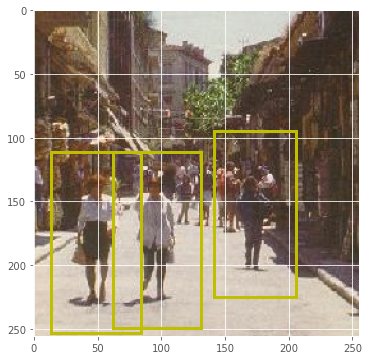

In [62]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
from matplotlib import patches
for f in found:
    ax.add_patch(patches.Rectangle((f[0], f[1]), f[2], f[3], color='y', linewidth=3, fill=False))
plt.savefig('detectado.png')